In [1]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans

##import lightgbm as lgb
##from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor

# model validation
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

SEED = 2
np.random.seed(SEED)

In [3]:
# renaming columns
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [4]:
train= pd.read_csv('~/aiffel/dataton/data/train.csv', encoding = 'cp949',  names=train_col, header=0)
test = pd.read_csv('~/aiffel/dataton/data/test.csv', encoding = 'cp949', names=test_col, header=0)
sub = pd.read_csv('~/aiffel/dataton/data/sample_submission.csv', encoding='cp949')

In [5]:
train_df = train.copy()

In [6]:
## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
# THI : 기온, 습도로 불쾌지수 계산 [1.8*기온 -0.55*(1-습도)*(1.8*기온-26)+32]
# - 쾌적/다소 불쾌/불쾌/ 매우 불쾌 [0, 68, 75, 80, 200] ?
train_df['THI'] = 9/5*train_df['temp'] - 0.55*(1-train_df['humid']/100)*(9/5*train_df['humid']-26)+32

In [7]:
train_df.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,THI
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,57.5376
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,57.0389
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,56.6789
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,55.9589
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,56.4576


In [8]:
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/C:/Windows/Fonts/NGULIM.TTF'

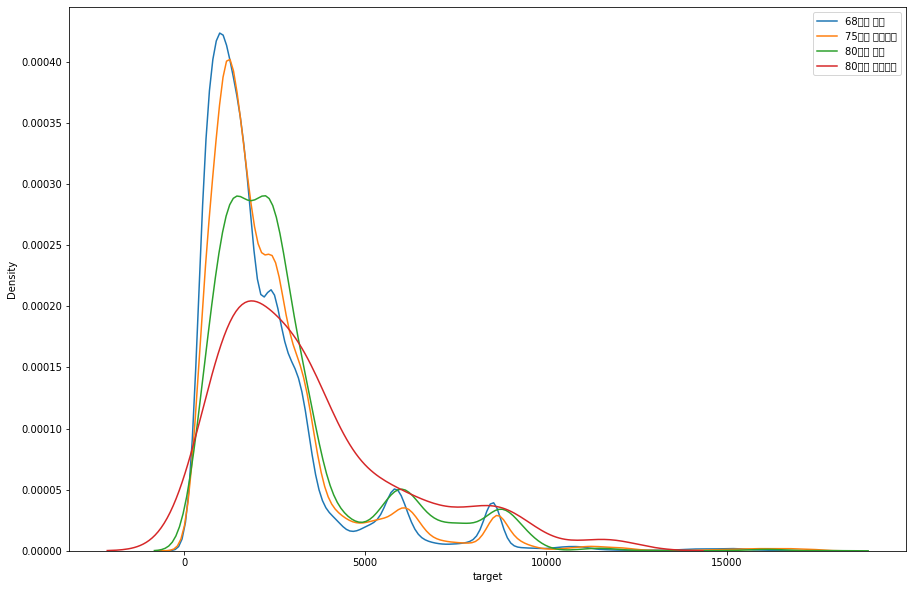

In [9]:
# 불괘지수에 따른 전력사용량의 histogram  : KDE (커널밀도추정) → kdeplot 사용

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.kdeplot(train_df[train_df['THI'] <=68 ]['target'], ax=ax)
sns.kdeplot(train_df[(train_df['THI'] >68) & (train_df['THI'] <=75)]['target'], ax=ax)
sns.kdeplot(train_df[(train_df['THI'] >75) & (train_df['THI'] <=80)]['target'], ax=ax)
sns.kdeplot(train_df[train_df['THI'] >80]['target'], ax=ax)
plt.legend(['68이하 괘적', '75이하 다소불쾌', '80이하 불쾌','80이상 매우불쾌'])
plt.show()

In [10]:
train_1 = train_df[train_df.num == 1]
train_1.shape

(2040, 11)

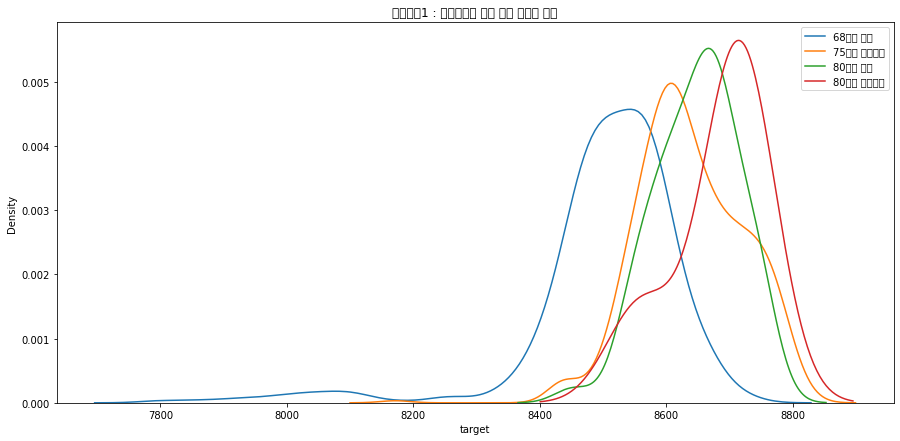

In [11]:
# 건물번호 1번 불괘지수에 따른 전력사용량의 histogram  : KDE (커널밀도추정) → kdeplot 사용

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.kdeplot(train_1[train_1['THI'] <=68 ]['target'], ax=ax)
sns.kdeplot(train_1[(train_1['THI'] >68) & (train_1['THI'] <=75)]['target'], ax=ax)
sns.kdeplot(train_1[(train_1['THI'] >75) & (train_1['THI'] <=80)]['target'], ax=ax)
sns.kdeplot(train_1[train_1['THI'] >80]['target'], ax=ax)
plt.legend(['68이하 괘적', '75이하 다소불쾌', '80이하 불쾌','80이상 매우불쾌'])
plt.title("건물번호1 : 불쾌지수에 따른 전력 사용량 변화")
plt.show()

<AxesSubplot:xlabel='sunny', ylabel='target'>

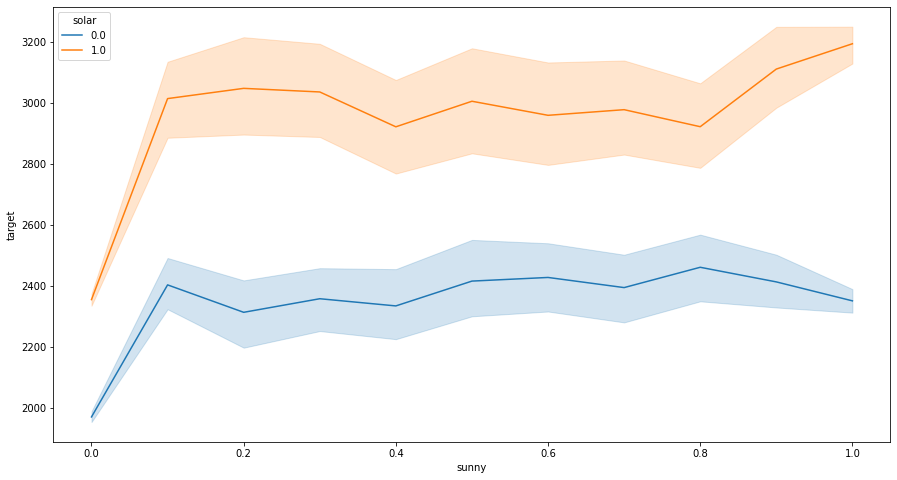

In [12]:
# 태양광 설치 여부에 따른 일조량과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'sunny', y = 'target', hue = 'solar', data = train_df)

<AxesSubplot:xlabel='temp', ylabel='target'>

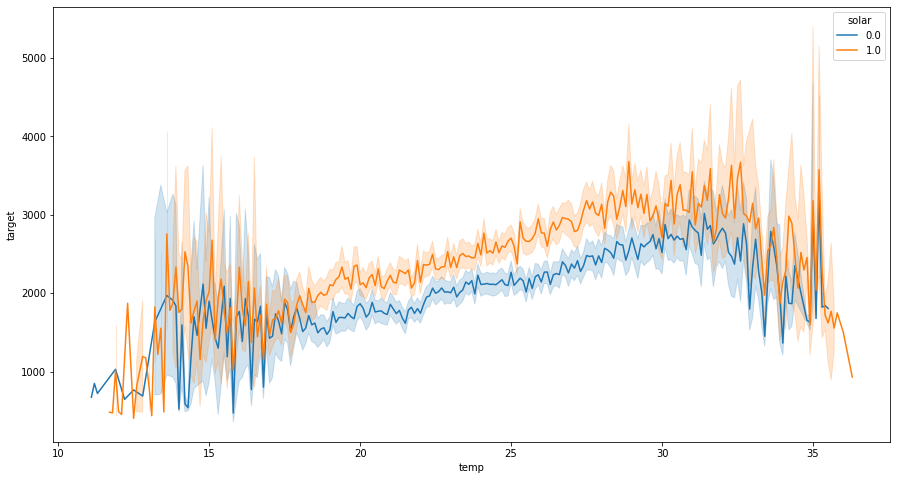

In [13]:
# 태양광 설치 여부에 따른 기온과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'temp', y = 'target', hue = 'solar', data = train_df)

<AxesSubplot:xlabel='temp', ylabel='target'>

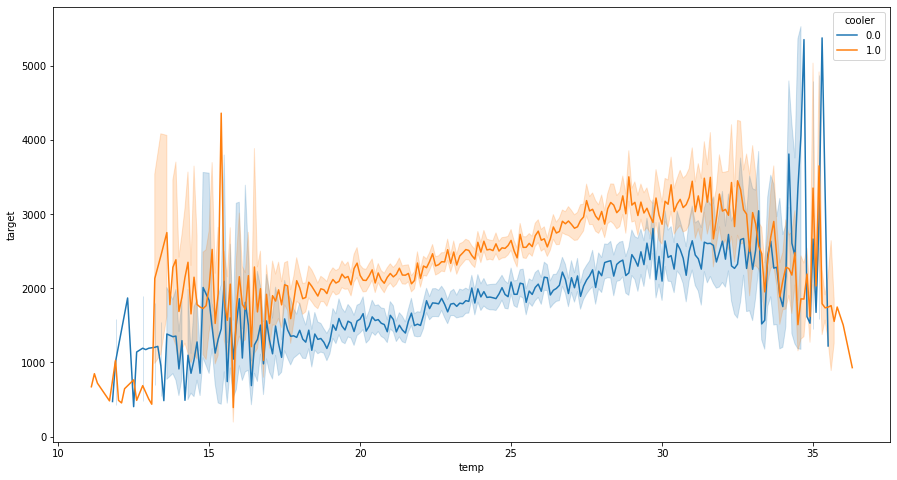

In [14]:
# 비전기냉방설비 운영 여부에 따른 기온과 전력사용량 비교
plt.figure(figsize = (15,8))
sns.lineplot(x = 'temp', y = 'target', hue = 'cooler', data = train_df)

In [15]:
def make_time(train):
    """
    시간 관련 변수를 추가하기 위한 함수
    """
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [16]:

train = make_time(train)
test = make_time(test)

In [17]:

train.loc[train.weekday >= 5, 'holiday'] = 1
train.loc[train.weekday < 5, 'holiday'] = 0
train.loc[(train.month == 8) & (train.day == 17), 'holiday'] = 1

test.loc[test.weekday >= 5, 'holiday'] = 1
test.loc[test.weekday < 5, 'holiday'] = 0

In [18]:
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

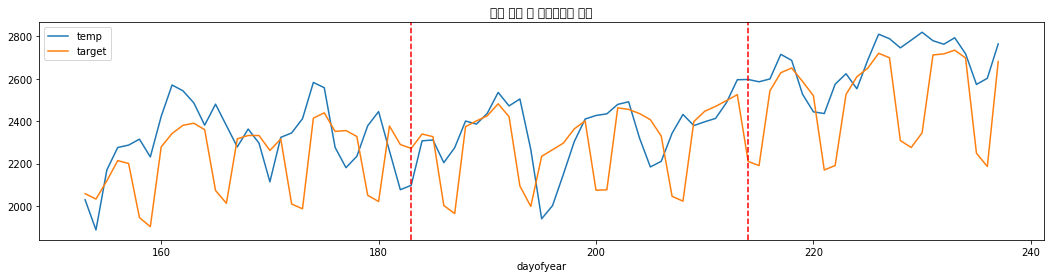

In [19]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

In [20]:
train.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,0.0


In [21]:
test.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,holiday
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,0.0
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,1,1,238,0.0
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,2,1,238,0.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,0.0,0.0,8,25,3,1,238,0.0
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,4,1,238,0.0


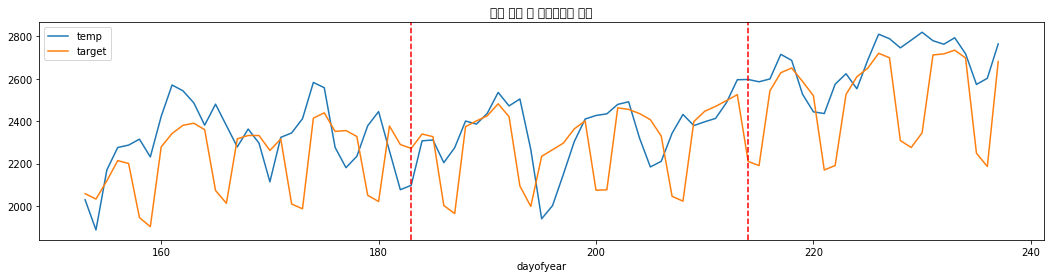

In [22]:
(train.groupby(['dayofyear'])['temp'].mean()*100).plot(figsize=(18, 4))
train.groupby(['dayofyear'])['target'].mean().plot(figsize=(18, 4))
plt.legend(['temp', 'target'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('일별 기온 및 전력사용량 추이')
plt.show()

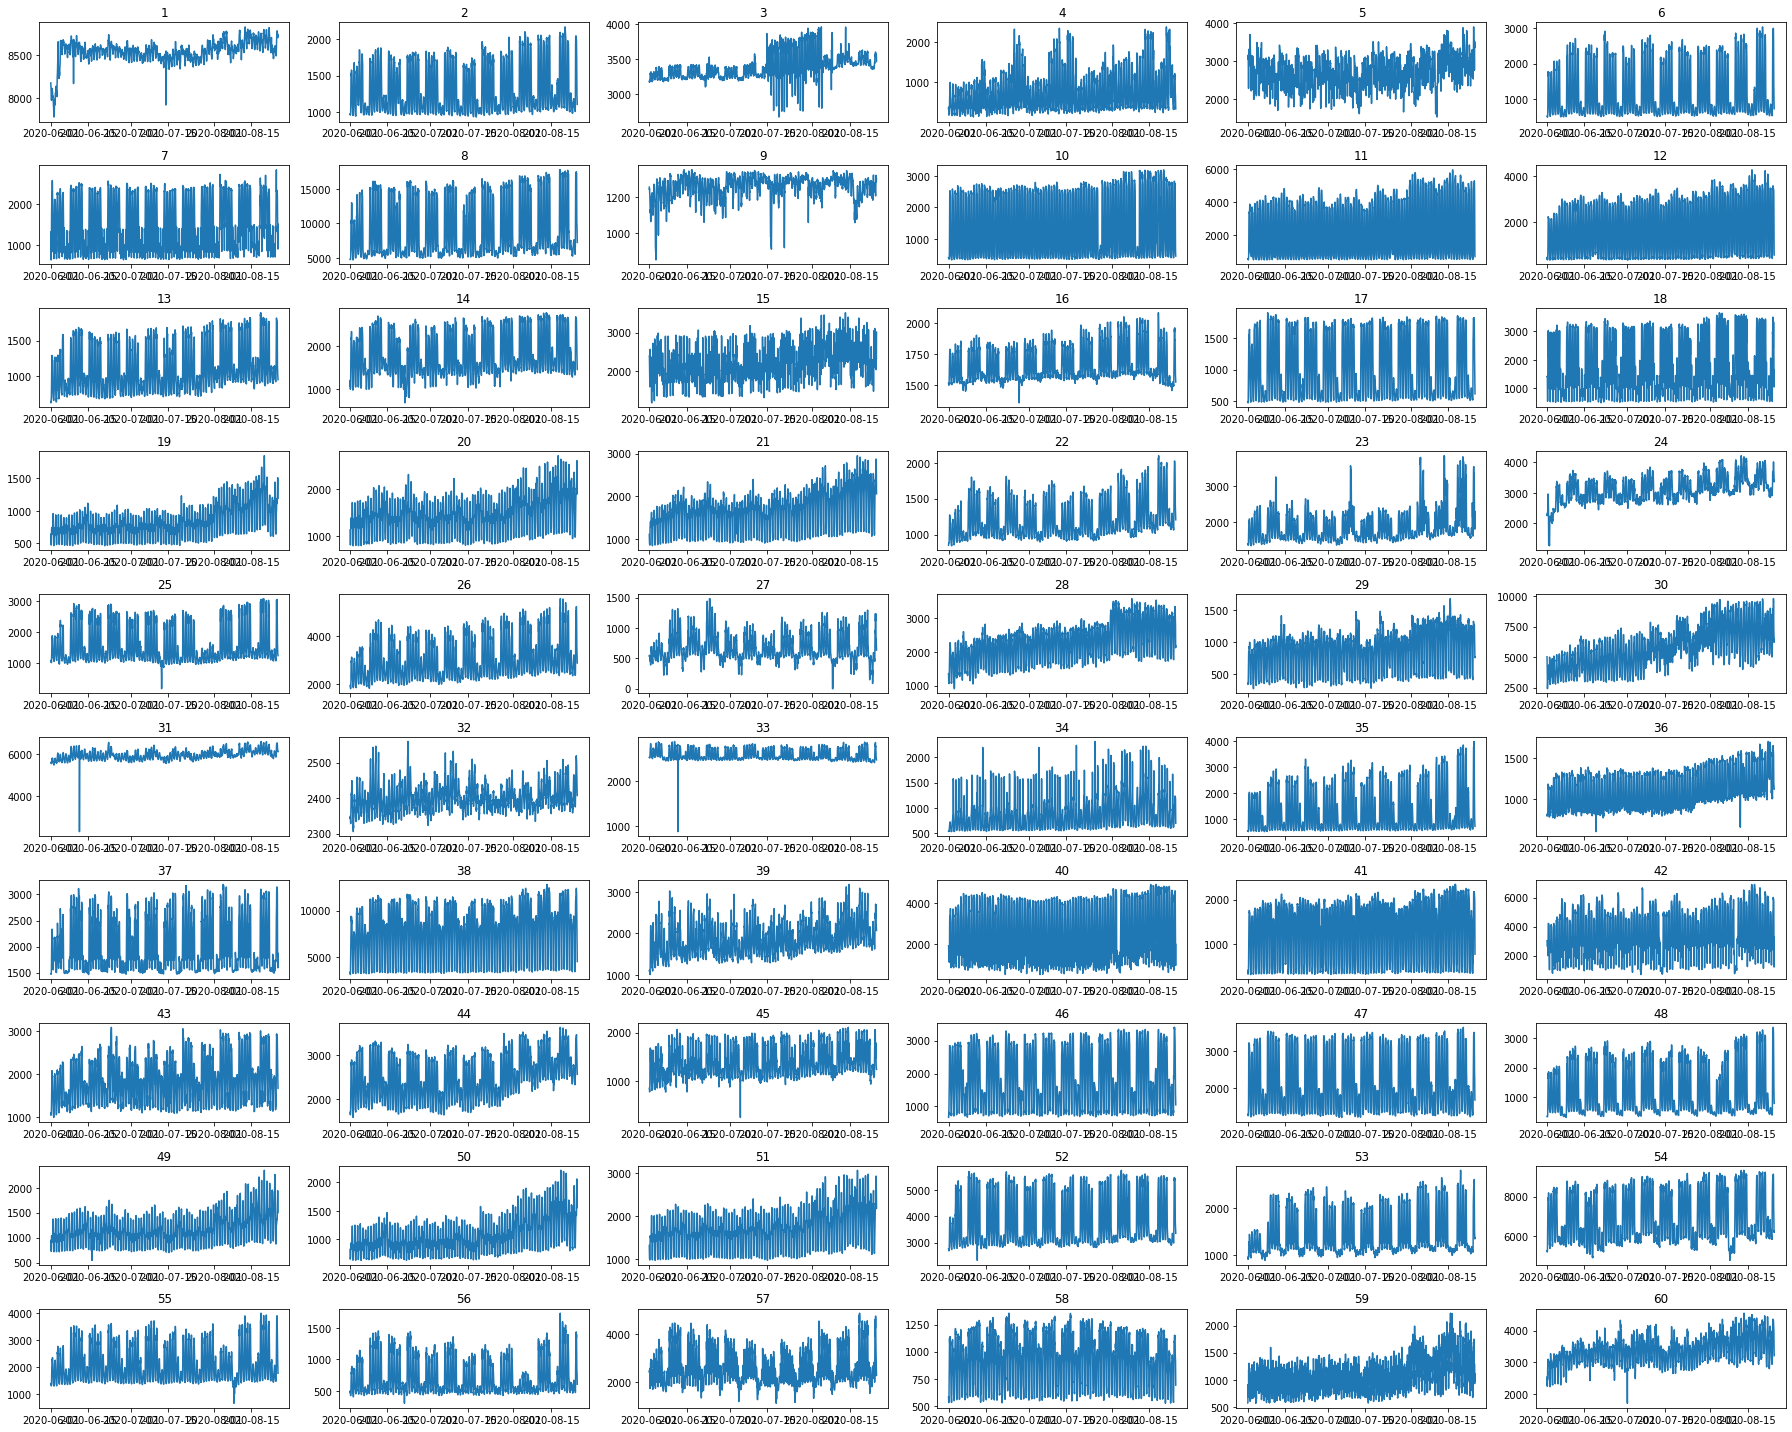

In [23]:
## 건물별로 시간에 따라서 전력사용량 시각화 시켜보기

plt.figure(figsize=(25, 20))

for i, j in enumerate(train['num'].unique().tolist()):
    ax = plt.subplot2grid((10, 6), (i//6, i%6))
    ax.plot(train.loc[train['num'] == j]['date_time'], train.loc[train['num'] == j]['target'])
    ax.set_title(j)
    
plt.tight_layout()
plt.show()

# 기후변화가 각 건물의 주간 총 전력량에 미치는 영향

In [24]:
# building 1번의 DF
building1_df = train_df[0:2040]

# building 1번의 주 단위 DF
# 한 주 기준 데이터의 인덱스 행 넘버가 총 168개
building1_w1 = building1_df[0:167]
building1_w2 = building1_df[168:336]
building1_w3 = building1_df[336:504]
building1_w4 = building1_df[504:672]
building1_w5 = building1_df[672:840]
building1_w6 = building1_df[840:1008]
building1_w7 = building1_df[1008:1176]
building1_w8 = building1_df[1176:1344]
building1_w9  = building1_df[1344:1512]
building1_w10 = building1_df[1512:1680]
building1_w11 = building1_df[1680:1848]
building1_w12 = building1_df[1848:2016]

b1w1kW = building1_w1['target']
b1w2kW = building1_w2['target']
b1w3kW = building1_w3['target']
b1w4kW = building1_w4['target']
b1w5kW = building1_w5['target']
b1w6kW = building1_w6['target']
b1w7kW = building1_w7['target']
b1w8kW = building1_w8['target']
b1w9kW = building1_w9['target']
b1w10kW = building1_w10['target']
b1w11kW = building1_w11['target']
b1w12kW = building1_w12['target']

building_kWw_column = [b1w1kW, b1w2kW, b1w3kW, b1w4kW, b1w5kW, b1w6kW, b1w7kW, b1w8kW, b1w9kW, b1w10kW, b1w11kW, b1w12kW]

In [25]:
# 주단위 총 전력량 합산

building1_kWw = []

np.sum(b1w1kW, axis=0)
building1_kWw.append(np.sum(b1w1kW, axis=0))

np.sum(b1w2kW, axis=0)
building1_kWw.append(np.sum(b1w2kW, axis=0))

np.sum(b1w3kW, axis=0)
building1_kWw.append(np.sum(b1w3kW, axis=0))

np.sum(b1w4kW, axis=0)
building1_kWw.append(np.sum(b1w4kW, axis=0))

np.sum(b1w5kW, axis=0)
building1_kWw.append(np.sum(b1w5kW, axis=0))

np.sum(b1w6kW, axis=0)
building1_kWw.append(np.sum(b1w6kW, axis=0))

np.sum(b1w7kW, axis=0)
building1_kWw.append(np.sum(b1w7kW, axis=0))

np.sum(b1w8kW, axis=0)
building1_kWw.append(np.sum(b1w8kW, axis=0))

np.sum(b1w9kW, axis=0)
building1_kWw.append(np.sum(b1w9kW, axis=0))

np.sum(b1w10kW, axis=0)
building1_kWw.append(np.sum(b1w10kW, axis=0))

np.sum(b1w11kW, axis=0)
building1_kWw.append(np.sum(b1w11kW, axis=0))

np.sum(b1w12kW, axis=0)
building1_kWw.append(np.sum(b1w12kW, axis=0))


building1_kWw

[1395615.7439999997,
 1439438.688,
 1434786.696,
 1438086.96,
 1430406.864,
 1431517.536,
 1422322.4160000002,
 1425055.68,
 1439267.616,
 1446019.7759999998,
 1457243.136,
 1452243.5639999998]

In [26]:
# 합산한 결과를 DF화

building1_kWw_df = pd.DataFrame(building1_kWw)

print(building1_kWw_df)

              0
0   1395615.744
1   1439438.688
2   1434786.696
3   1438086.960
4   1430406.864
5   1431517.536
6   1422322.416
7   1425055.680
8   1439267.616
9   1446019.776
10  1457243.136
11  1452243.564


In [27]:
# 주단위 평균 온도

b1w1t = building1_w1['temp']
b1w2t = building1_w2['temp']
b1w3t = building1_w3['temp']
b1w4t = building1_w4['temp']
b1w5t = building1_w5['temp']
b1w6t = building1_w6['temp']
b1w7t = building1_w7['temp']
b1w8t = building1_w8['temp']
b1w9t = building1_w9['temp']
b1w10t = building1_w10['temp']
b1w11t = building1_w11['temp']
b1w12t = building1_w12['temp']

building_tpt_column = [b1w1t, b1w2t, b1w3t, b1w4t, b1w5t, b1w6t, b1w7t, b1w8t, b1w9t, b1w10t, b1w11t, b1w12t]

In [28]:
# 주단위 평균 온도

building1_tpt = []

np.mean(b1w1t, axis=0)
building1_tpt.append(np.mean(b1w1t, axis=0))

np.mean(b1w2t, axis=0)
building1_tpt.append(np.mean(b1w2t, axis=0))

np.mean(b1w3t, axis=0)
building1_tpt.append(np.mean(b1w3t, axis=0))

np.mean(b1w4t, axis=0)
building1_tpt.append(np.mean(b1w4t, axis=0))

np.mean(b1w5t, axis=0)
building1_tpt.append(np.mean(b1w5t, axis=0))

np.mean(b1w6t, axis=0)
building1_tpt.append(np.mean(b1w6t, axis=0))

np.mean(b1w7t, axis=0)
building1_tpt.append(np.mean(b1w7t, axis=0))

np.mean(b1w8t, axis=0)
building1_tpt.append(np.mean(b1w8t, axis=0))

np.mean(b1w9t, axis=0)
building1_tpt.append(np.mean(b1w9t, axis=0))

np.mean(b1w10t, axis=0)
building1_tpt.append(np.mean(b1w10t, axis=0))

np.mean(b1w11t, axis=0)
building1_tpt.append(np.mean(b1w11t, axis=0))

np.mean(b1w12t, axis=0)
building1_tpt.append(np.mean(b1w12t, axis=0))


building1_tpt

[21.691017964071854,
 25.63273809523809,
 24.326785714285716,
 24.375,
 23.227976190476188,
 25.264880952380953,
 23.260714285714286,
 23.760119047619046,
 24.83154761904762,
 25.14345238095238,
 26.728571428571428,
 26.64702380952381]

In [29]:
# 평균 온도 DF화
building1_tpt_df = pd.DataFrame(building1_tpt)

print(building1_tpt_df)

            0
0   21.691018
1   25.632738
2   24.326786
3   24.375000
4   23.227976
5   25.264881
6   23.260714
7   23.760119
8   24.831548
9   25.143452
10  26.728571
11  26.647024


In [30]:
# 주단위 총 일조량

b1w1s = building1_w1['sunny']
b1w2s = building1_w2['sunny']
b1w3s = building1_w3['sunny']
b1w4s = building1_w4['sunny']
b1w5s = building1_w5['sunny']
b1w6s = building1_w6['sunny']
b1w7s = building1_w7['sunny']
b1w8s = building1_w8['sunny']
b1w9s = building1_w9['sunny']
b1w10s= building1_w10['sunny']
b1w11s= building1_w11['sunny']
b1w12s= building1_w12['sunny']

building_tps_column = [b1w1s, b1w2s, b1w3s, b1w4s, b1w5s, b1w6s, b1w7s, b1w8s, b1w9s, b1w10s, b1w11s, b1w12s]

In [31]:
# 주단위 총 일조량

building1_tps = []

np.sum(b1w1s, axis=0)
building1_tps.append(np.sum(b1w1s, axis=0))

np.sum(b1w2s, axis=0)
building1_tps.append(np.sum(b1w2s, axis=0))

np.sum(b1w3s, axis=0)
building1_tps.append(np.sum(b1w3s, axis=0))

np.sum(b1w4s, axis=0)
building1_tps.append(np.sum(b1w4s, axis=0))

np.sum(b1w5s, axis=0)
building1_tps.append(np.sum(b1w5s, axis=0))

np.sum(b1w6s, axis=0)
building1_tps.append(np.sum(b1w6s, axis=0))

np.sum(b1w7s, axis=0)
building1_tps.append(np.sum(b1w7s, axis=0))

np.sum(b1w8s, axis=0)
building1_tps.append(np.sum(b1w8s, axis=0))

np.sum(b1w9s, axis=0)
building1_tps.append(np.sum(b1w9s, axis=0))

np.sum(b1w10s, axis=0)
building1_tps.append(np.sum(b1w10s, axis=0))

np.sum(b1w11s, axis=0)
building1_tps.append(np.sum(b1w11s, axis=0))

np.sum(b1w12s, axis=0)
building1_tps.append(np.sum(b1w12s, axis=0))


building1_tps

[52.5,
 55.7,
 54.80000000000001,
 41.4,
 32.8,
 36.4,
 31.4,
 12.5,
 8.0,
 2.5,
 5.4,
 34.400000000000006]

In [32]:
# 총 일조량 DF화
building1_tps_df = pd.DataFrame(building1_tps)

print(building1_tps_df)

       0
0   52.5
1   55.7
2   54.8
3   41.4
4   32.8
5   36.4
6   31.4
7   12.5
8    8.0
9    2.5
10   5.4
11  34.4


In [33]:
# 주단위 총 강수량

b1w1r = building1_w1['rain']
b1w2r = building1_w2['rain']
b1w3r = building1_w3['rain']
b1w4r = building1_w4['rain']
b1w5r = building1_w5['rain']
b1w6r = building1_w6['rain']
b1w7r = building1_w7['rain']
b1w8r = building1_w8['rain']
b1w9r = building1_w9['rain']
b1w10r= building1_w10['rain']
b1w11r= building1_w11['rain']
b1w12r= building1_w12['rain']

building_tpr_column = [b1w1r, b1w2r, b1w3r, b1w4r, b1w5r, b1w6r, b1w7r, b1w8r, b1w9r, b1w10r, b1w11r, b1w12r]

In [34]:
# 주단위 총 강수량

building1_tpr = []

np.sum(b1w1r, axis=0)
building1_tpr.append(np.sum(b1w1r, axis=0))

np.sum(b1w2r, axis=0)
building1_tpr.append(np.sum(b1w2r, axis=0))

np.sum(b1w3r, axis=0)
building1_tpr.append(np.sum(b1w3r, axis=0))

np.sum(b1w4r, axis=0)
building1_tpr.append(np.sum(b1w4r, axis=0))

np.sum(b1w5r, axis=0)
building1_tpr.append(np.sum(b1w5r, axis=0))

np.sum(b1w6r, axis=0)
building1_tpr.append(np.sum(b1w6r, axis=0))

np.sum(b1w7r, axis=0)
building1_tpr.append(np.sum(b1w7r, axis=0))

np.sum(b1w8r, axis=0)
building1_tpr.append(np.sum(b1w8r, axis=0))

np.sum(b1w9r, axis=0)
building1_tpr.append(np.sum(b1w9r, axis=0))

np.sum(b1w10r, axis=0)
building1_tpr.append(np.sum(b1w10r, axis=0))

np.sum(b1w11r, axis=0)
building1_tpr.append(np.sum(b1w11r, axis=0))

np.sum(b1w12r, axis=0)
building1_tpr.append(np.sum(b1w12r, axis=0))


building1_tpr

[3.4,
 7.300000000000001,
 0.1,
 53.0,
 78.3,
 5.1,
 88.1,
 121.20000000000002,
 124.80000000000001,
 270.1,
 211.00000000000003,
 45.1]

In [35]:
# 총 강수량 DF화
building1_tpr_df = pd.DataFrame(building1_tpr)

print(building1_tpr_df)

        0
0     3.4
1     7.3
2     0.1
3    53.0
4    78.3
5     5.1
6    88.1
7   121.2
8   124.8
9   270.1
10  211.0
11   45.1


In [36]:
# 주단위 평균 습도

b1w1h = building1_w1['humid']
b1w2h = building1_w2['humid']
b1w3h = building1_w3['humid']
b1w4h = building1_w4['humid']
b1w5h = building1_w5['humid']
b1w6h = building1_w6['humid']
b1w7h = building1_w7['humid']
b1w8h = building1_w8['humid']
b1w9h = building1_w9['humid']
b1w10h= building1_w10['humid']
b1w11h= building1_w11['humid']
b1w12h= building1_w12['humid']

building_tph_column = [b1w1h, b1w2h, b1w3h, b1w4h, b1w5h, b1w6h, b1w7h, b1w8h, b1w9h, b1w10h, b1w11h, b1w12h]

In [37]:
# 주단위 평균 습도

building1_tph = []

np.mean(b1w1h, axis=0)
building1_tph.append(np.mean(b1w1h, axis=0))

np.mean(b1w2h, axis=0)
building1_tph.append(np.mean(b1w2h, axis=0))

np.mean(b1w3h, axis=0)
building1_tph.append(np.mean(b1w3h, axis=0))

np.mean(b1w4h, axis=0)
building1_tph.append(np.mean(b1w4h, axis=0))

np.mean(b1w5h, axis=0)
building1_tph.append(np.mean(b1w5h, axis=0))

np.mean(b1w6h, axis=0)
building1_tph.append(np.mean(b1w6h, axis=0))

np.mean(b1w7h, axis=0)
building1_tph.append(np.mean(b1w7h, axis=0))

np.mean(b1w8h, axis=0)
building1_tph.append(np.mean(b1w8h, axis=0))

np.mean(b1w9h, axis=0)
building1_tph.append(np.mean(b1w9h, axis=0))

np.mean(b1w10h, axis=0)
building1_tph.append(np.mean(b1w10h, axis=0))

np.mean(b1w11h, axis=0)
building1_tph.append(np.mean(b1w11h, axis=0))

np.mean(b1w12h, axis=0)
building1_tph.append(np.mean(b1w12h, axis=0))


building1_tph

[70.08982035928143,
 62.44642857142857,
 61.595238095238095,
 71.56547619047619,
 72.93452380952381,
 69.2797619047619,
 76.41666666666667,
 79.92857142857143,
 88.63095238095238,
 91.45238095238095,
 87.9702380952381,
 79.83928571428571]

In [38]:
# 평균 습도 DF화
building1_tph_df = pd.DataFrame(building1_tph)

print(building1_tph_df)

            0
0   70.089820
1   62.446429
2   61.595238
3   71.565476
4   72.934524
5   69.279762
6   76.416667
7   79.928571
8   88.630952
9   91.452381
10  87.970238
11  79.839286


In [39]:
# 주단위 평균 풍속

b1w1w = building1_w1['wind']
b1w2w = building1_w2['wind']
b1w3w = building1_w3['wind']
b1w4w = building1_w4['wind']
b1w5w = building1_w5['wind']
b1w6w = building1_w6['wind']
b1w7w = building1_w7['wind']
b1w8w = building1_w8['wind']
b1w9w = building1_w9['wind']
b1w10w= building1_w10['wind']
b1w11w= building1_w11['wind']
b1w12w= building1_w12['wind']

building_tpw_column = [b1w1w, b1w2w, b1w3w, b1w4w, b1w5w, b1w6w, b1w7w, b1w8w, b1w9w, b1w10w, b1w11w, b1w12w]

In [40]:
# 주단위 평균 풍속

building1_tpw = []

np.mean(b1w1w, axis=0)
building1_tpw.append(np.mean(b1w1w, axis=0))

np.mean(b1w2w, axis=0)
building1_tpw.append(np.mean(b1w2w, axis=0))

np.mean(b1w3w, axis=0)
building1_tpw.append(np.mean(b1w3w, axis=0))

np.mean(b1w4w, axis=0)
building1_tpw.append(np.mean(b1w4w, axis=0))

np.mean(b1w5w, axis=0)
building1_tpw.append(np.mean(b1w5w, axis=0))

np.mean(b1w6w, axis=0)
building1_tpw.append(np.mean(b1w6w, axis=0))

np.mean(b1w7w, axis=0)
building1_tpw.append(np.mean(b1w7w, axis=0))

np.mean(b1w8w, axis=0)
building1_tpw.append(np.mean(b1w8w, axis=0))

np.mean(b1w9w, axis=0)
building1_tpw.append(np.mean(b1w9w, axis=0))

np.mean(b1w10w, axis=0)
building1_tpw.append(np.mean(b1w10w, axis=0))

np.mean(b1w11w, axis=0)
building1_tpw.append(np.mean(b1w11w, axis=0))

np.mean(b1w12w, axis=0)
building1_tpw.append(np.mean(b1w12w, axis=0))


building1_tpw

[2.4077844311377246,
 2.1851190476190476,
 2.107142857142857,
 2.3333333333333335,
 2.454761904761905,
 2.3154761904761907,
 2.3863095238095235,
 2.8934523809523807,
 2.0297619047619047,
 2.692857142857143,
 2.4583333333333335,
 1.9047619047619047]

In [41]:
# 평균 풍속 DF화
building1_tpw_df = pd.DataFrame(building1_tpw)

print(building1_tpw_df)

           0
0   2.407784
1   2.185119
2   2.107143
3   2.333333
4   2.454762
5   2.315476
6   2.386310
7   2.893452
8   2.029762
9   2.692857
10  2.458333
11  1.904762


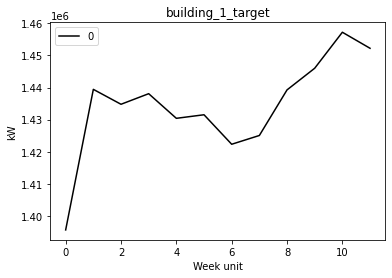

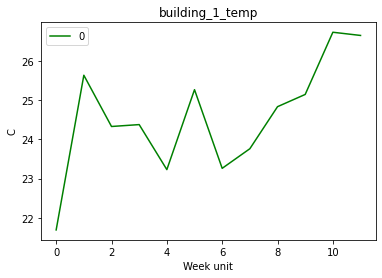

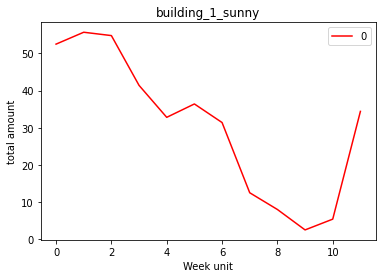

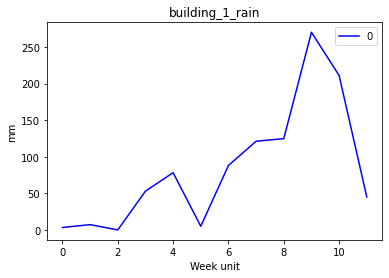

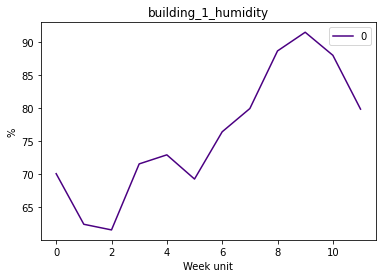

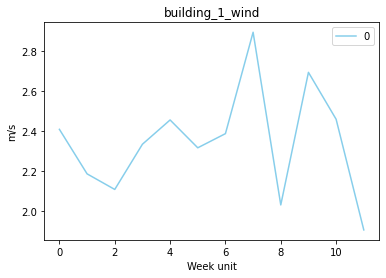

In [43]:
# 시각화

# 총 전력량
building1_kWw_df.plot(color='black')
plt.title("building_1_target")
plt.ylabel("kW")
plt.xlabel("Week unit")

# 주간 평균 온도
building1_tpt_df.plot(color='green')
plt.title("building_1_temp")
plt.ylabel("C")
plt.xlabel("Week unit")

# 주간 총 일조량
building1_tps_df.plot(color='red')
plt.title("building_1_sunny")
plt.ylabel("total amount")
plt.xlabel("Week unit")

# 주간 총 강수량
building1_tpr_df.plot(color='blue')
plt.title("building_1_rain")
plt.ylabel("mm")
plt.xlabel("Week unit")

# 주간 평균 습도
building1_tph_df.plot(color='indigo')
plt.title("building_1_humidity")
plt.ylabel("%")
plt.xlabel("Week unit")

# 주간 평균 풍속
building1_tpw_df.plot(color='skyblue')
plt.title("building_1_wind")
plt.ylabel("m/s")
plt.xlabel("Week unit")


plt.show()

In [ ]:
(train.groupby(['dayofyear'])['rain'].sum()).plot(kind='bar', figsize=(18, 4))
plt.title('일별 강수량 추이')
plt.show()

In [ ]:
train.groupby(['dayofyear'])['sunny'].sum().plot(kind='bar', figsize=(18, 4))
plt.title('일별 일조량 추이')
plt.show()

In [ ]:
train_origin = train.copy()

In [ ]:
for i in range(1, 61):
    mean_ = train.loc[train.num == i].target.mean()
    std_ = train.loc[train.num == i].target.std()
    train.loc[train.num == i, 'target'] = ((train.loc[train.num == i, 'target']) - mean_) / std_

In [ ]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [ ]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [ ]:
cl_df = pd.concat([weekday_mean, hour_mean], axis=1)

In [ ]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
)

cl_df.columns = columns

In [ ]:
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    plt.xticks(rotation=45)

In [ ]:
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [ ]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [ ]:
cl_df['km_cluster'] = pred

In [ ]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [ ]:
test_cl = test.copy()

In [ ]:
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [ ]:
km_0 = list(train_cl.loc[train_cl.km_cluster == 0].num.unique())
km_1 = list(train_cl.loc[train_cl.km_cluster == 1].num.unique())
km_2 = list(train_cl.loc[train_cl.km_cluster == 2].num.unique())
km_3 = list(train_cl.loc[train_cl.km_cluster == 3].num.unique())

In [ ]:
train_cl.groupby(['km_cluster'])['num'].count().to_frame()/2040

In [ ]:
fig = plt.figure(figsize=(18, np.ceil(len(km_0)/6)*4))
for i, n in enumerate(km_0):
    plt.subplot(np.ceil(len(km_0)/6), 6, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [ ]:
fig = plt.figure(figsize=(15, np.ceil(len(km_1)/5)*4))
for i, n in enumerate(km_1):
    plt.subplot(np.ceil(len(km_1)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [ ]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [ ]:
fig = plt.figure(figsize=(15, np.ceil(len(km_2)/5)*4))
for i, n in enumerate(km_2):
    plt.subplot(np.ceil(len(km_2)/5), 5, i+1)
    plt.title("{} heatmap".format(n))
    sns.heatmap(train.loc[train.num == n].groupby(['weekday', 'hour'])['target'].mean().unstack().T)

In [ ]:
plt.figure(figsize=(18, 4))
sns.heatmap(train_cl.groupby(['km_cluster', 'hour', 'weekday'])['target'].mean().unstack().T)
plt.show()

In [ ]:
from scipy.stats import pearsonr

In [ ]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)

In [ ]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [ ]:
cl_df['km_cluster'] = pred

In [ ]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [ ]:
corrs_temp = train_cl.groupby(['km_cluster', 'num'])['target'].mean().to_frame()

In [ ]:
temp = train_cl.groupby(['num'])['cooler', 'solar'].max()

In [ ]:
corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].temp,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['temp_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].humid,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['humid_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].sunny,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['sunny_corr'] = corrs

corrs = []
for i in range(1, 61):
    corr, _ = pearsonr(train.loc[train.num == i].wind,
                       train.loc[train.num == i].target)
    corrs.append(corr)
temp['wind_corr'] = corrs

In [ ]:
corrs_cl_temp = pd.merge(corrs_temp, temp, how='left', on='num').set_index(corrs_temp.index).round(2)

### 기온에 영향

In [ ]:
corrs_temp_temp = (corrs_cl_temp.temp_corr
                   .reset_index()
                   .sort_values(by=['temp_corr'], ascending=False)
                  .set_index(['num'], drop=False))

In [ ]:
plt.figure(figsize=(18, 1))
plt.title('1_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_temp-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['temp_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 습도에 영향

In [ ]:
corrs_temp_temp = (corrs_cl_temp.humid_corr
                   .reset_index()
                   .sort_values(by=['humid_corr'], ascending=True)
                  .set_index(['num'], drop=False))

In [ ]:
plt.figure(figsize=(18, 1))
plt.title('1_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_humid-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['humid_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

### 바람의 영향

In [ ]:
corrs_temp_temp = (corrs_cl_temp.wind_corr
                   .reset_index()
                   .sort_values(by=['wind_corr'], ascending=False)
                  .set_index(['num'], drop=False))

In [ ]:
plt.figure(figsize=(18, 1))
plt.title('1_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 0]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('2_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 1]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('3_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 2]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()

plt.figure(figsize=(18, 1))
plt.title('4_wind-target_corr')
sns.heatmap(corrs_temp_temp.loc[corrs_temp_temp.km_cluster == 3]['wind_corr'].to_frame().T,
           annot=True, linewidths=.5, vmin=-1, vmax=1)
plt.show()